# Uncertainty ellipsoid

In [2]:
using Revise

In [3]:
using LowRankVortex

[ Info: Precompiling LowRankVortex [fdf095b8-6f21-420b-9d49-8e692abb03d1]


In [4]:
using PotentialFlow

In [5]:
using CairoMakie
#using Plots
#pyplot()

In [6]:
using LaTeXStrings

In [7]:
using Distributions
using Random
using LinearAlgebra
using GaussianMixtures
using Statistics

### Truth

In [8]:
LowRankVortex.get_config_and_state(Nv;kwargs...) = get_config_and_state(default_vortex(Nv)...;kwargs...)

default_vortex(Nv) = _default_vortex(Val(Nv))

function _default_vortex(::Val{1})
    zv = [0.5+1.0im]
    Γv = [1.0] 
    return zv, Γv
end

function _default_vortex(::Val{2})
    zv = [-1.0+0.75im,0.75+0.5im]  # [-1.0+0.75im,0.75+0.5im]
    Γv = [1.2,0.4] #[1.2,0.4] #[1.2,-1.0] 
    return zv, Γv
end

function _default_vortex(::Val{3})
    zv = [-0.75+0.5im,0.25+0.5im,0.75+0.75im]
    Γv = [1.0,-1.2,1.4]
    return zv, Γv
end

_default_vortex (generic function with 3 methods)

### Set some plotting themes

In [9]:
xytheme = Theme(
        Axis = (aspect=DataAspect(),xlabel=L"x",ylabel=L"y"),
        palette = (color = Makie.wong_colors(),),
        Lines = (cycle = [:color],),
        Scatter = (cycle = [:color],)
    );

sensortheme = Theme(
    Axis = (xlabel="Sensor no.",ylabel=L"p-p_\infty")
);

#### Set up the observer for the truth data

In [10]:
Nv_true = 1
Nsens = 3

ϵmeas_data = [2.5e-4,3.75e-4,5e-4,6.25e-4,8e-4,1e-3,1.5e-3,2e-3,3e-3,4e-3];
ϵmeas = ϵmeas_data[3] #5e-4 #1e-3

config_true, x_true = get_config_and_state(Nv_true)
obs_true, ystar, H, Σϵ, Σx = get_truth_data(Nsens,ϵmeas,x_true,config_true);

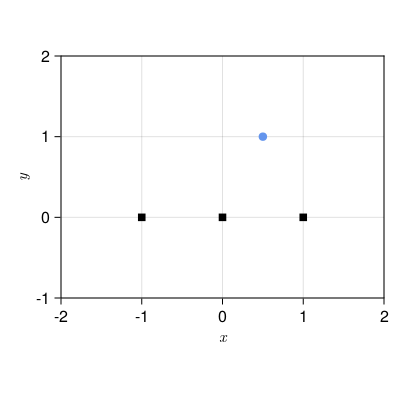

In [11]:
with_theme(xytheme) do
    f = Figure(;resolution = (400, 400))
    ax = f[1,1] = Axis(f;limits=(-2,2,-1,2))
    show_singularities!(ax,x_true,obs_true)
    plot_sensors!(ax,obs_true)
    f
end

### Evaluate the true sensor data and add noise

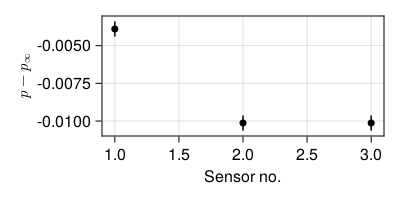

In [12]:
with_theme(sensortheme) do
    f = Figure(;resolution = (400, 200))
    ax = f[1,1] = Axis(f)
    plot_sensor_data!(ax,ystar,obs_true;sensor_noise=ϵmeas*ones(length(ystar)))
    f
end

In [13]:
xid, yid, Γid = get_singularity_ids(obs_true.config)

([1], [2], [3])

### Get the Jacobian

In [18]:
#Σx = inv(H'*inv(Σϵ)*H)

In [59]:
Nsens = 3
zv, Γv = default_vortex(1)
#zv .+= 0.42*[1,-1]
#Γv = [1.2,-1.0]
config_true, x_true = get_config_and_state(zv,Γv,δ=0.01,blobstate=false)
obs_true, ystar, H, Σϵ, Σx = get_truth_data(Nsens,ϵmeas,x_true,config_true,layout=(:line,1.0));
#F = eigen(Σx);

In [60]:
config_true

VortexConfig{LowRankVortex.NoWall, DataType, Dict{Any, Any}}(1, Dict{Any, Any}("vortex Γ transform" => [1.0;;], "vortex y" => [2], "vortex Γ" => [3], "vortex Γ total" => 3, "vortex x" => [1], "vortex Γ inverse transform" => [1.0;;]), LowRankVortex.NoWall, 0.0 + 0.0im, 0.0, 0.01, false)

In [62]:
Σx

3×3 Matrix{Float64}:
 0.00190374  0.00178504  0.0014278
 0.00178504  0.0199209   0.0153155
 0.0014278   0.0153155   0.0120601

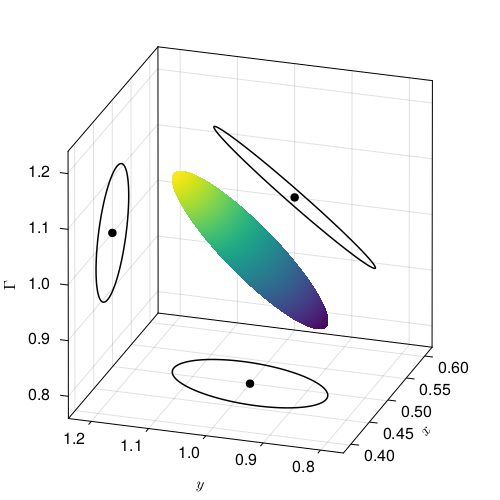

In [64]:
fig = Figure(;resolution=(500,500))
az = 1.1π #1.4π
el = π/8 #π/8
ax = fig[1,1] = Axis3(fig;aspect=(1,1,1),azimuth=az,elevation=el,xlabel=L"x",ylabel=L"y",zlabel=L"\Gamma")

s = svd(Σx)
US = s.U*Diagonal(sqrt.(s.S))
xmax = 1.2.*ceil.(maximum(abs.(US),dims=2),digits=1)
draw_ellipse_x!(ax,x_true[[2,3]],Σx[[2,3],[2,3]],x_true[1]+xmax[1],color=:black)
draw_ellipse_y!(ax,x_true[[3,1]],Σx[[3,1],[3,1]],x_true[2]+xmax[2],color=:black)
draw_ellipse_z!(ax,x_true[[1,2]],Σx[[1,2],[1,2]],x_true[3]-xmax[3],color=:black)

scatter!(ax,[x_true[1]],[x_true[2]],[x_true[3]-xmax[3]],color=:black)
scatter!(ax,[x_true[1]+xmax[1]],[x_true[2]],[x_true[3]],color=:black)
scatter!(ax,[x_true[1]],[x_true[2]+xmax[2]],[x_true[3]],color=:black)

draw_ellipsoid!(ax,x_true,Σx,shading=false)
limits!(ax,x_true[1]-xmax[1],x_true[1]+xmax[1],x_true[2]-xmax[2],x_true[2]+xmax[2],x_true[3]-xmax[3],x_true[3]+xmax[3])

save("covar-ellipsoid-1vortex.svg",fig)
fig

In [50]:
Σx

3×3 Matrix{Float64}:
 0.0088764   0.0130252  0.00694675
 0.0130252   0.103959   0.0531034
 0.00694675  0.0531034  0.0277043

#### Include a column in H for blobs

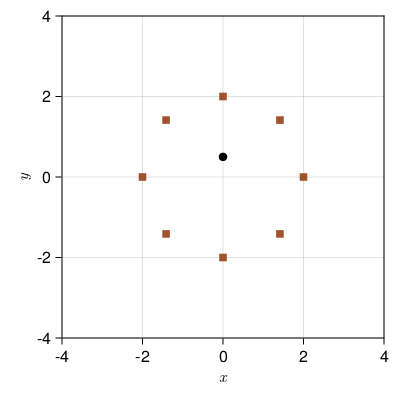

In [415]:
with_theme(xytheme) do
    f = Figure(;resolution = (400, 400))
    ax = f[1,1] = Axis(f;limits=(-4,4,-4,4))
    show_singularities!(ax,x_true,obs_true,color=:black)
    plot_sensors!(ax,obs_true,color=:sienna)
    f
end

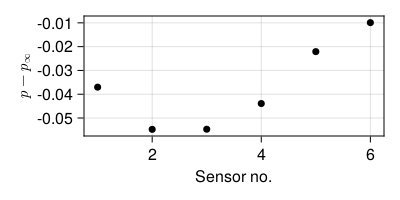

In [64]:
with_theme(sensortheme) do
    f = Figure(;resolution = (400, 200))
    ax = f[1,1] = Axis(f)
    plot_sensor_data!(ax,ystar,obs_true;sensor_noise=ϵmeas*ones(length(ystar)))
    f
end

In [1163]:
Nsenslist = 3:8
dzvlist = -2.0:0.005:1.0
xsenslist = 0.25:0.05:4.0

δlist = 10.0.^(-2:0.05:0.0)
#dzvlist = -1.0:0.005:0.875-0.005

#zv, Γv = default_vortex(2)
#zv .+= 0.75*[1,-1]
#Γv = [1.2,-1.0]
#Γv = [1.2,0.4]
Hlist = Matrix[]
Flist00 = Eigen[]
Fsvdlist = SVD[]
xseplist = Float64[]
for Nsens in Nsenslist[2]
    #for dzv in dzvlist
for δ in δlist[1]
    for xs in xsenslist
        zv, Γv = default_vortex(1)
        zv = [0.0+1.0im]
        #zv .+= dzv
        #zv .+= dzv*[1,-1]
        #Γv = [1.2,-1.0]
        #Γv = [1.2,0.4]
        config_true, x_true = get_config_and_state(zv,Γv,δ=δ,blobstate=false)
        obs_true, ystar, H, Σϵ, Σx = get_truth_data(Nsens,ϵmeas,x_true,config_true,layout=(:line,xs))
        #F = rank(Σx) == state_length(config_true) ? eigen(inv(Σx)) : eigen(Σx)
        F = eigen(Σx)
        Fsvd = svd(H)
        push!(Hlist,deepcopy(H))
        push!(Flist00,deepcopy(F))
        push!(Fsvdlist,deepcopy(Fsvd))
        #push!(xseplist,real(zv[2]-zv[1]))
        push!(xseplist,real(zv[1]))
        end
    end
end

In [1172]:
sort(range(0,1,length=31))

0.0:0.03333333333333333:1.0

In [1147]:
Hlist[1]*4π^2

3×3 Matrix{Float64}:
  0.22137  0.88548  -0.940999
 -0.0      0.9996   -0.9998
 -0.22137  0.88548  -0.940999

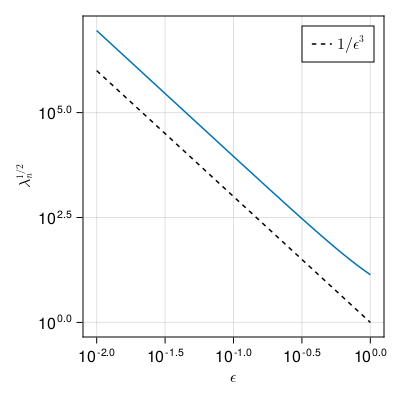

In [222]:
f = Figure(;resolution=(400,400))
ax = f[1,1] = Axis(f;xscale=log10,yscale=log10,xlabel=L"\varepsilon",ylabel=L"\lambda_n^{1/2}")
lines!(ax,δlist,[sqrt(Fj.values[end]) for Fj in Flist])
lines!(ax,δlist,1.0./δlist.^3,label=L"1/\varepsilon^3",color=:black,linestyle=:dash)
axislegend(ax)
#save("maxcovar-1vortex-blobradius.svg",f)
f

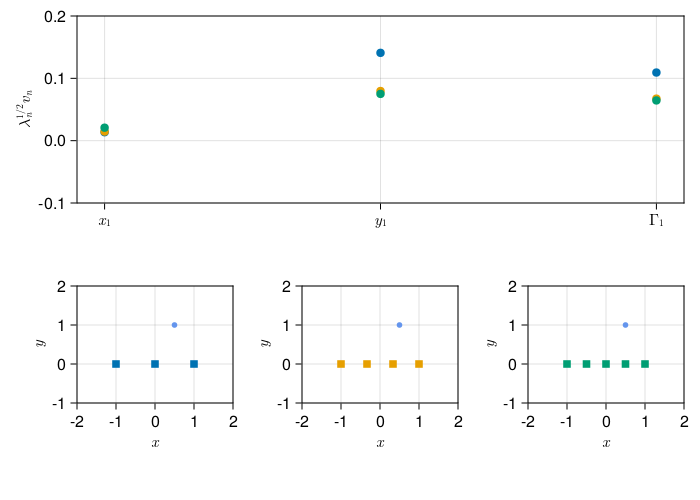

In [53]:
f = Figure(;resolution=(700,500))

ga = f[1,1] = GridLayout()
gb = f[2,1] = GridLayout()
gb1 = gb[1,1] = GridLayout()
gb2 = gb[1,2] = GridLayout()
gb3 = gb[1,3] = GridLayout()

select = [1,2,3]

axleft = Axis(ga[1,1];xticks=(1:3,[L"x_1",L"y_1",L"\Gamma_1"]),ylabel=L"\lambda_n^{1/2} v_n")
for j in 1:3
    selj = select[j]
    sgn = Flist[selj].vectors[3,end]/abs(Flist[selj].vectors[3,end])
    scatter!(axleft,sqrt(Flist[selj].values[end])*sgn*Flist[selj].vectors[:,end],label=L"d=%$(Nsenslist[selj])")
end
ylims!(axleft,(-0.1,0.2))
#axislegend(axleft,position=:rb)
with_theme(xytheme) do
    axright = [Axis(gb[1,1];limits=(-2,2,-1,2)),Axis(gb[1,2];limits=(-2,2,-1,2)),Axis(gb[1,3];limits=(-2,2,-1,2))]
    for j in 1:3
        selj = select[j]
        zv, Γv = default_vortex(1)
        config_true, x_true = get_config_and_state(zv,Γv)
        obs_true, ystar, H, Σϵ, Σx = get_truth_data(Nsenslist[selj],ϵmeas,x_true,config_true)
        show_singularities!(axright[j],x_true,obs_true,markersize=8)
        plot_sensors!(axright[j],obs_true,color=Makie.wong_colors()[j])
    end
end
save("maxvariance-1vortex-varyd-G1p.svg",f)
f

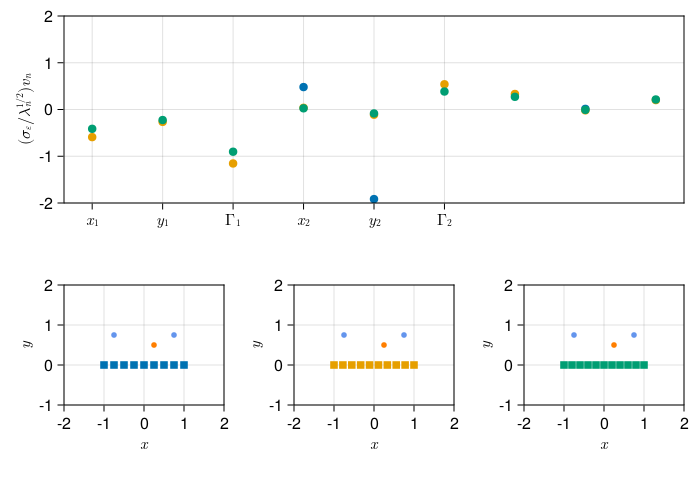

In [17]:
f = Figure(;resolution=(700,500))

ga = f[1,1] = GridLayout()
gb = f[2,1] = GridLayout()
gb1 = gb[1,1] = GridLayout()
gb2 = gb[1,2] = GridLayout()
gb3 = gb[1,3] = GridLayout()

select = [1,2,3]

axleft = Axis(ga[1,1];xticks=(1:6,[L"x_1",L"y_1",L"\Gamma_1",L"x_2",L"y_2",L"\Gamma_2"]),ylabel=L"(\sigma_\epsilon/\lambda_n^{1/2})v_n")
for j in 1:3
    selj = select[j]
    scatter!(axleft,sqrt(Flist[selj].values[end])*Flist[selj].vectors[:,end],label=L"d=%$(Nsenslist[selj])")
end
ylims!(axleft,(-2,2))
#axislegend(axleft,position=:rb)
with_theme(xytheme) do
    axright = [Axis(gb[1,1];limits=(-2,2,-1,2)),Axis(gb[1,2];limits=(-2,2,-1,2)),Axis(gb[1,3];limits=(-2,2,-1,2))]
    for j in 1:3
        selj = select[j]
        zv, Γv = default_vortex(3)
        config_true, x_true = get_config_and_state(zv,Γv)
        obs_true, ystar, H, Σϵ, Σx = get_truth_data(Nsenslist[selj],ϵmeas,x_true,config_true)
        show_singularities!(axright[j],x_true,obs_true,markersize=8)
        plot_sensors!(axright[j],obs_true,color=Makie.wong_colors()[j])
    end
end
#save("maxvariance-2vortex-varyd-G1p-G2p-case4.svg",f)
f

In [1170]:
Hlist[end]'*Hlist[end]

3×3 Matrix{Float64}:
  3.85524e-5   -2.91168e-22  -2.85874e-21
 -2.91168e-22   2.15628e-5   -6.01195e-5
 -2.85874e-21  -6.01195e-5    0.000170725

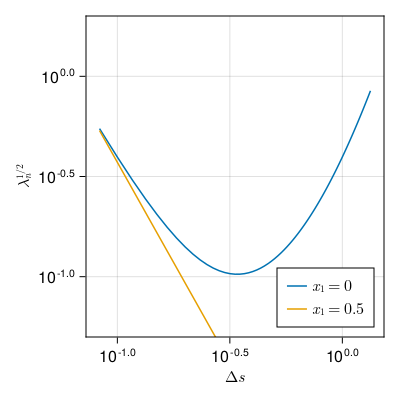

In [1167]:
f = Figure(;resolution=(400,400))

ax = f[1,1] = Axis(f;xscale=log10,yscale=log10,xlabel=L"\Delta s",ylabel=L"\lambda_n^{1/2}")
#λrootmax3 = [sqrt(Flist3[j].values[end]) for j in 1:length(Flist3)]
#λrootmax4 = [sqrt(Flist4[j].values[end]) for j in 1:length(Flist4)]
#λrootmax5 = [sqrt(Flist5[j].values[end]) for j in 1:length(Flist5)]
λrootmax00 = [maximum(sqrt.(Flist00[j].values)) for j in 1:length(Flist00)]
λrootmax05 = [maximum(sqrt.(Flist05[j].values)) for j in 1:length(Flist05)]


#axleft = Axis(ga[1,1];xticks=(1:6,[L"x_1",L"y_1",L"\Gamma_1",L"x_2",L"y_2",L"\Gamma_2"]),ylabel=L"(\sigma_\epsilon/\lambda_n^{1/2})v_n")
#lines!(ax,xseplist,λrootmax3,label=L"d=3")
#lines!(ax,xseplist,λrootmax4,label=L"d=4")
#lines!(ax,xseplist,λrootmax5,label=L"d=5")
lines!(ax,xsenslist/(length(obs_true.sens)-1),λrootmax00,label=L"x_1=0")
#lines!(ax,xsenslist/(length(obs_true.sens)-1),λrootmax05,label=L"x_1=0.5")

lines!(ax,xsenslist/(length(obs_true.sens)-1),0.2*5e-4*(xsenslist/(length(obs_true.sens)-1)).^(-2)/sqrt(9/8)*(4π^2),label=L"x_1=0.5")


axislegend(ax,position=:rb)
#xlims!(ax,(-1.5,1.5))
#xlims!(ax,(0.9,1.0))
ylims!(ax,(0.05,2))

#save("maxcovar-1vortex-G1p-4sensor-varyds.svg",f)

f

In [91]:
diff(zv + dzvlist[end]*[1,-1])

1-element Vector{ComplexF64}:
 0.0 - 0.25im

In [183]:
val, idx = findmax(λrootmax6)
dzvlist[idx]
zv, Γv = default_vortex(2)
zv .+= dzvlist[xseplist.≈0.91].*[1,-1]

2-element Vector{ComplexF64}:
 -0.5800000000000001 + 0.75im
                0.33 + 0.5im

In [1]:
Hlist[1]

LoadError: UndefVarError: Hlist not defined

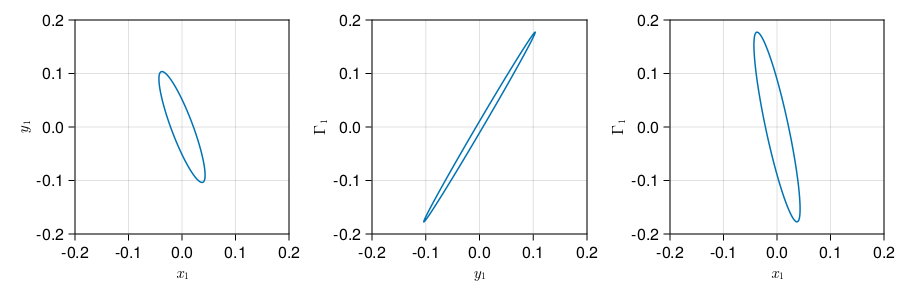

In [88]:
f = Figure(;resolution=(900,300))
f[1, 1] = GridLayout()
f[1, 2] = GridLayout()
f[1, 3] = GridLayout()

vort1, vort2 = 1, 1
ax11 = Axis(f[1,1];xlabel=L"x_%$vort1",ylabel=L"y_%$vort2",aspect=DataAspect())

vec = [xid[vort1],yid[vort2]]
draw_ellipse!(ax11,zeros(2),Σx[vec,vec])
ylims!(ax11,(-0.2,0.2))
xlims!(ax11,(-0.2,0.2))

ax12 = Axis(f[1,2];xlabel=L"y_%$vort1",ylabel=L"\Gamma_%$vort2",aspect=DataAspect())

vec = [yid[vort1],Γid[vort2]]
draw_ellipse!(ax12,zeros(2),Σx[vec,vec])
ylims!(ax12,(-0.2,0.2))
xlims!(ax12,(-0.2,0.2))

ax13 = Axis(f[1,3];xlabel=L"x_%$vort1",ylabel=L"\Gamma_%$vort2",aspect=DataAspect())

vec = [xid[vort1],Γid[vort2]]
draw_ellipse!(ax13,zeros(2),Σx[vec,vec])
ylims!(ax13,(-0.2,0.2))
xlims!(ax13,(-0.2,0.2))
f

In [1119]:
A = hcat(real(zv).-real(obs_true.sens),imag(zv).-imag(obs_true.sens),ones(4)) #,0.01*ones(4))

4×3 Matrix{Float64}:
  1.5       1.0  1.0
  0.833333  1.0  1.0
  0.166667  1.0  1.0
 -0.5       1.0  1.0

In [1120]:
svd(A)

SVD{Float64, Float64, Matrix{Float64}, Vector{Float64}}
U factor:
4×3 Matrix{Float64}:
 -0.627309   0.553609  -0.547723
 -0.535306   0.115962   0.730297
 -0.443304  -0.321686   0.182574
 -0.351301  -0.759334  -0.365148
singular values:
3-element Vector{Float64}:
 3.0517829790885673
 1.3816087980204546
 7.618837888342103e-17
Vt factor:
3×3 Matrix{Float64}:
 -0.421159  -0.641337  -0.641337
  0.906987  -0.297804  -0.297804
 -0.0        0.707107  -0.707107